## Importing libraries used

In [31]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from skimage.color import rgb2lab, lab2rgb
import os
from skimage.color import deltaE_cie76

%matplotlib inline

## Working with OpenCV

loading the image selected and understand the operations we'll use on it

Shape of image: (168, 301, 3)


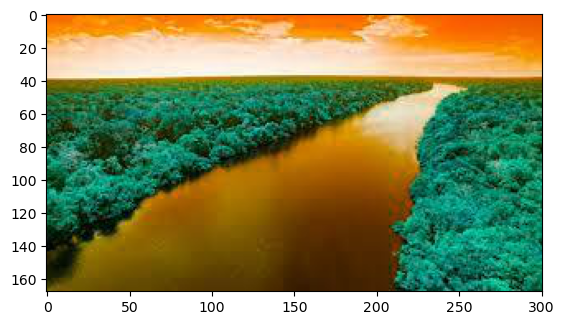

In [32]:
image = cv2.imread('Images/image1.jpg')
print('Shape of image:', image.shape)
plt.imshow(image)

As noticed the image has different colours than the original. This is a result of OpenCV reading colours in the order of BGR, therefore we need to change it to RGB

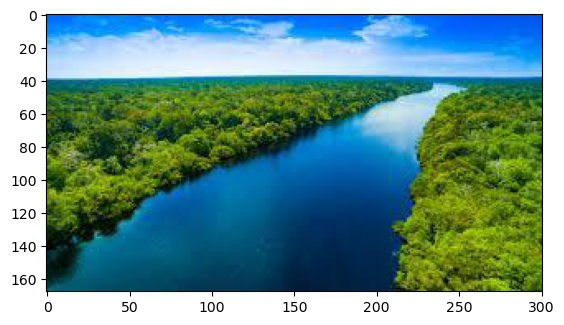

In [33]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In order to identify the colours of an image we'll need to create a function that returns the hex value of colours

In [34]:
def rgb_to_hex(colour):
    return '#{:02x}{:02x}{:02x}'.format(int(colour[0]), int(colour[1]), int(colour[2]))

KMeans expects a flattened array as input during the fitting. Therefore, we'll need to reshape the image with numpy and then apply KMeans to first fit and then predict on the image for a result. After that the clustered colours are identified and arranged

In [35]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [36]:
def get_colours(image, n_of_colours, show_chart):
    modified_image = cv2.resize(image, (600, 400), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)
    kmeans = KMeans(n_clusters=n_of_colours)
    labels = kmeans.fit_predict(modified_image)
    counts = Counter(labels)
    counts = dict(sorted(counts.items()))

    center_colours = kmeans.cluster_centers_
    ordered_colours = [center_colours[i] for i in counts.keys()]
    hex_colours = [rgb_to_hex(ordered_colours[i]) for i in counts.keys()]
    rgb_colours = [ordered_colours[i] for i in counts.keys()]

    if show_chart:
        plt.figure(figsize=(8, 6))
        plt.pie(counts.values(), labels=hex_colours, colors=np.array(ordered_colours) / 255.0)
        plt.show()
    return rgb_colours

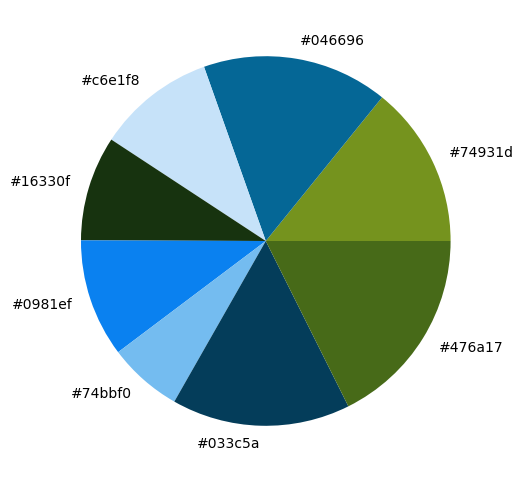

[array([116.71941682, 147.08004014,  29.54006434]),
 array([  4.95738899, 102.71897754, 150.1780843 ]),
 array([198.23922187, 225.95890965, 248.7747715 ]),
 array([22.63931833, 51.0537022 , 15.4041678 ]),
 array([  9.97662704, 129.01225065, 239.65782793]),
 array([116.351566  , 187.50938321, 240.39736117]),
 array([ 3.77799712, 60.67782639, 90.17401163]),
 array([ 71.49899648, 106.157635  ,  23.57006918])]

In [37]:
get_colours(get_image('Images/image1.jpg'), 8, True)

From the model we can extract major colours, this allows for the opportunity to search for images according to certain colours.

We select a colour and if its hex value matches or is close to that of a major colour then it's a match.

In [38]:
image_directory = 'Images'
Colours = {
    'Green' : [0, 128, 0],
    'Blue' : [0, 0, 128],
    'Orange' : [255, 165, 0],
}
images = []
for filename in os.listdir(image_directory):
    if not filename.startswith('.jpg'):
        images.append(get_image(os.path.join(image_directory, filename)))

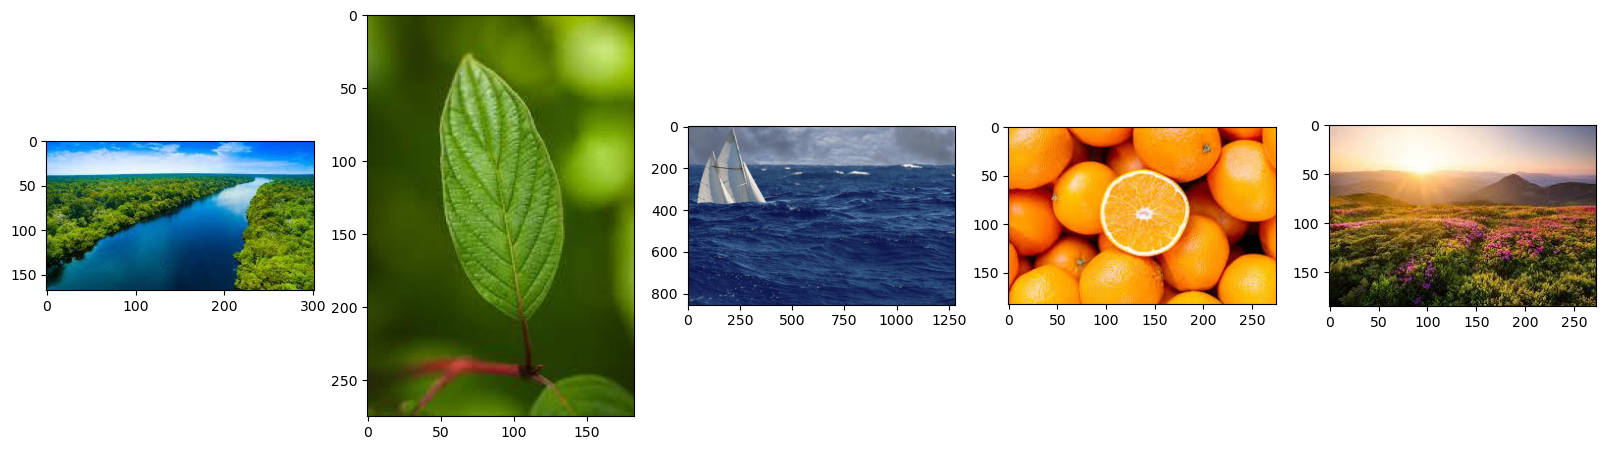

In [39]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])

A match function is defined below where it tried to match with the top 10 colours of the image, it's possible the matches will not be exact, therefore we calculate the similarity between the chosen colour and the image

In [40]:


def match_img_colours(image, colour, threshold = 60, number_of_colours = 10):
    image_colours = get_colours(image, number_of_colours, False)
    selected_colour = rgb2lab(np.uint8(np.asarray([[colour]])))
    selected_image = False

    for i in range(number_of_colours):
        current_colour = rgb2lab(np.uint8(np.asarray([[image_colours[i]]])))
        difference = deltaE_cie76(selected_colour, current_colour)
        if difference < threshold:
            selected_image = True
    
    return selected_image

The method above is called for all the images and show the relevant images that match the selected colour

In [41]:
def show_matched_images(colour, threshold, colours_match):
    index = 1
    for i in range(len(images)):
        selected = match_img_colours(
            images[i],
            colour, 
            threshold, 
            colours_match
        )
        if selected:
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            plt.title(f'Matched with {colour}')
            index += 1

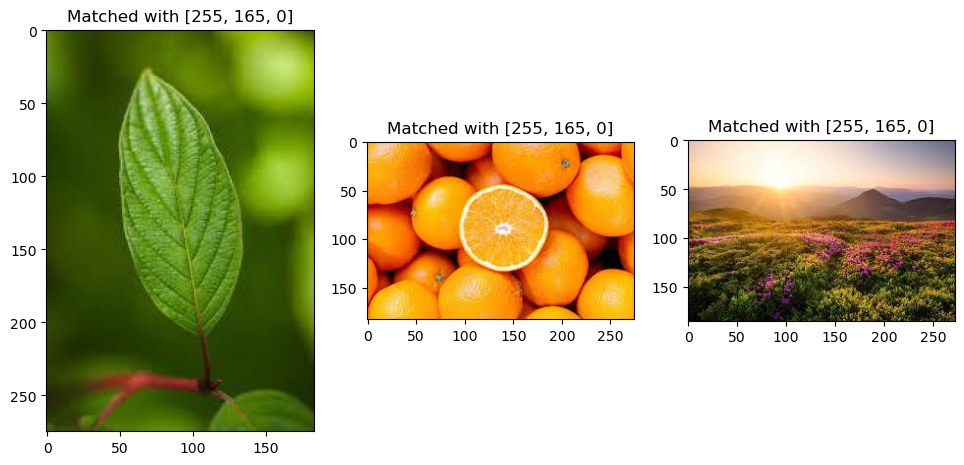

In [42]:
plt.figure(figsize=(20, 10))
show_matched_images(Colours['Orange'], 60, 5)

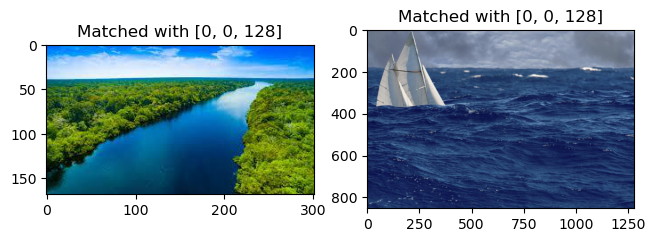

In [43]:
plt.figure(figsize=(20, 10))
show_matched_images(Colours['Blue'], 60, 5)

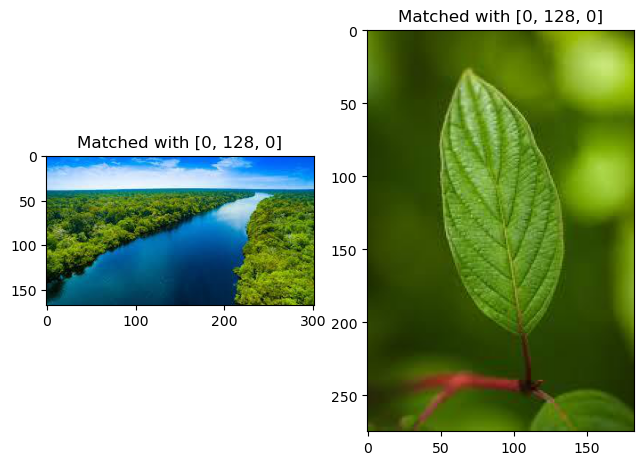

In [44]:
plt.figure(figsize=(20, 10))
show_matched_images(Colours['Green'], 60, 5)